In [1]:
import math
from pathlib import Path
import os

import pandas as pd
import numpy as numpy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import vaex as vx
from tqdm import tqdm

color_pal = sns.color_palette()
sns.set_palette("Set2")

# HOME = Path(os.environ['HOME'])
HOME = Path("/notebooks")
# HOME = Path("/mnt/c/Users/isabe")
# PROJECT = HOME / "Documents/repos/eagle-comp"
PROJECT = HOME / "eagle-comp"
DATA = PROJECT / "data"
EAGLE_DATA = Path("/datasets/eagle-comp")

In [2]:
def add_zeroes(outage_df):
    outage_df = outage_df.reset_index()
    outage_df['run_start_time'] = pd.to_datetime(outage_df['run_start_time'])
    outage_df['run_start_time'] = outage_df['run_start_time'].dt.round('15min')
    outage_df = outage_df.set_index(["fips_code", "run_start_time"]).sort_index()
    na_rows = outage_df[outage_df['sum'].isna()].index
    outage_df = outage_df.groupby('fips_code').apply(lambda g: g.loc[g.index.get_level_values(0)[0]].resample('15T').first().fillna(0))
    outage_df.loc[na_rows] = np.nan
    outage_df.reset_index(inplace=True)
    return outage_df

In [3]:
def plot_ts(df, col):
    rows = 9
    fig = plt.figure(figsize=(10, 3*rows))
    for i, year in enumerate(years()):
        data = df[df['year'] == year]
        if data.shape[0] == 0:
            rows -= 1
            fig.set_size_inches(10, 3*rows)
            continue
        plt.subplot(rows, 1, i % rows + 1)
        plt.title(year)
        # col has multiple columns
        if isinstance(col, list):
            for c in col:
                sns.lineplot(data=data, x=data.index, y=c, label=c)
        else:
            sns.lineplot(data=data, x=data.index, y=col, label=col)
        plt.legend()
    county, state = df[['county', 'state']].iloc[0]
    plt.suptitle(f"{county}, {state}", y=1, fontsize=16)
    plt.tight_layout()
    return plt.gcf()

In [4]:
years = lambda: range(2014, 2023)
df = []
for year in tqdm(years()):
    csv = pd.read_csv(EAGLE_DATA / f"eaglei_outages_{year}.csv", parse_dates=['run_start_time'])
    csv = csv.where(csv['fips_code'].isin([6037, 72113, 1031, 17031, 48051])).dropna()
    csv = add_zeroes(csv) 
    csv['fips_code'] = csv['fips_code'].astype('int')
    # csv = vx.from_pandas(csv)
    # csv = vx.read_csv(EAGLE_DATA / f"eaglei_outages_{year}.csv")
    df.append(csv)
    del csv
# df = vx.concat(df)
df = pd.concat(df)
# df['run_start_time'] = df['run_start_time'].astype('datetime64[ns]')

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [03:19<00:00, 22.13s/it]


In [5]:
df = df.drop(columns="index").set_index(['fips_code', 'run_start_time']).sort_index()

In [4]:
df = pd.read_csv(EAGLE_DATA / "eaglei_outages_2022.csv", parse_dates=["run_start_time"])

In [5]:
df = df.set_index(["fips_code", "run_start_time"]).sort_index()
df['year'] = df.index.get_level_values("run_start_time").year

In [6]:
df = add_zeroes(df)

In [7]:
df = df.set_index(['fips_code', 'run_start_time']).sort_index()

## Seasonal Decomposition

In [13]:
df.loc[72113, 'sum']

0.0

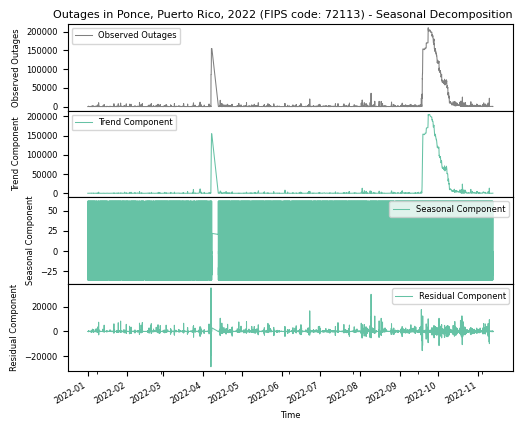

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

def seasonal_decomp_plot(df, fips):
    decompose = seasonal_decompose(df.loc[fips, 'sum'].interpolate(), model='additive', period=16)
    decomp_df = pd.DataFrame({
        'trend': decompose.trend, 
        'seasonal': decompose.seasonal, 
        'residual': decompose.resid,
        'observed': decompose.observed,
        'year': df.loc[fips, 'year'],
        })
    county, state = df.loc[fips, ['county', 'state']].iloc[0]
    decomp_df = decomp_df.where(decomp_df['year'] == 2022).dropna()
    fig, ax = plt.subplots(4, 1, figsize=(5.75, 4.625), sharex=True)
    label_font_size = 6
    legend_font_size = 6
    # set line width to 0.5
    plt.rcParams['lines.linewidth'] = 0.75

    decomp_df[['observed']].plot(ax=ax[0], color='grey', label='Observed Outages')
    ax[0].set_ylabel('Observed Outages', fontsize=label_font_size)
    ax[0].legend(["Observed Outages"], fontsize=legend_font_size)
    decomp_df[['trend']].plot(ax=ax[1], label='Trend Component')
    ax[1].set_ylabel('Trend Component', fontsize=label_font_size)
    ax[1].legend(["Trend Component"], fontsize=legend_font_size)
    decomp_df[['seasonal']].plot(ax=ax[2], label='Seasonal Component')
    ax[2].set_ylabel('Seasonal Component', fontsize=label_font_size)
    ax[2].legend(["Seasonal Component"], fontsize=legend_font_size)
    decomp_df[['residual']].plot(ax=ax[3], label='Residual Component')
    ax[3].set_ylabel('Residual Component', fontsize=label_font_size)
    ax[3].legend(["Residual Component"], fontsize=legend_font_size)

    # plt.legend()
    # for i in range(4):
    #     # ax[i].get_legend().remove()
    #     ax[i].legend()
    ax[-1].set_xlabel('Time', fontsize=6)
    # set font size of ylabels, xlabels, legend, and ticks
    for i in range(4):
        ax[i].tick_params(axis='y', labelsize=6)
        ax[i].tick_params(axis='x', labelsize=6)
        # ax[i].legend(fontsize=6)
    # ax[0].legend(["Observed Outages"], fontsize=4)
    # plt.legend()

    plt.subplots_adjust(hspace=0)
    # adjust top vertical space
    fig.subplots_adjust(top=0.95)
    plt.suptitle(f'Outages in {county}, {state}, 2022 (FIPS code: {fips}) - Seasonal Decomposition', fontsize=8)
    # get rid of horizontal space between suptitle and subplot
    # plt.show()
    return fig

fig = seasonal_decomp_plot(df, 72113)


In [11]:
fig.savefig("ponce-puerto-rico-seasonal-decomp-medium.pdf", bbox_inches='tight')

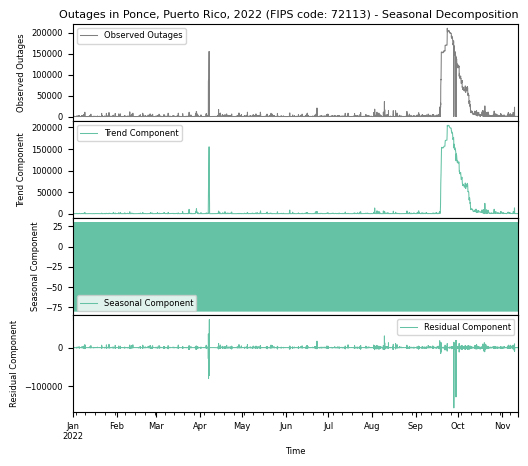

In [114]:
from statsmodels.tsa.seasonal import seasonal_decompose

def seasonal_decomp_plot(df, fips):
    decompose = seasonal_decompose(df.loc[fips, 'sum'].interpolate(), model='additive', period=16)
    decomp_df = pd.DataFrame({
        'trend': decompose.trend, 
        'seasonal': decompose.seasonal, 
        'residual': decompose.resid,
        'observed': decompose.observed,
        'year': df.loc[fips, 'year'],
        })
    county, state = df.loc[fips, ['county', 'state']].iloc[0]
    decomp_df = decomp_df.where(decomp_df['year'] == 2022).dropna()
    fig, ax = plt.subplots(4, 1, figsize=(5.75, 4.625), sharex=True)
    label_font_size = 6
    legend_font_size = 6
    # set line width to 0.5
    plt.rcParams['lines.linewidth'] = 0.75

    decomp_df[['observed']].plot(ax=ax[0], color='grey', label='Observed Outages')
    ax[0].set_ylabel('Observed Outages', fontsize=label_font_size)
    ax[0].legend(["Observed Outages"], fontsize=legend_font_size)
    decomp_df[['trend']].plot(ax=ax[1], label='Trend Component')
    ax[1].set_ylabel('Trend Component', fontsize=label_font_size)
    ax[1].legend(["Trend Component"], fontsize=legend_font_size)
    decomp_df[['seasonal']].plot(ax=ax[2], label='Seasonal Component')
    ax[2].set_ylabel('Seasonal Component', fontsize=label_font_size)
    ax[2].legend(["Seasonal Component"], fontsize=legend_font_size)
    decomp_df[['residual']].plot(ax=ax[3], label='Residual Component')
    ax[3].set_ylabel('Residual Component', fontsize=label_font_size)
    ax[3].legend(["Residual Component"], fontsize=legend_font_size)

    # plt.legend()
    # for i in range(4):
    #     # ax[i].get_legend().remove()
    #     ax[i].legend()
    ax[-1].set_xlabel('Time', fontsize=6)
    # set font size of ylabels, xlabels, legend, and ticks
    for i in range(4):
        ax[i].tick_params(axis='y', labelsize=6)
        ax[i].tick_params(axis='x', labelsize=6)
        # ax[i].legend(fontsize=6)
    # ax[0].legend(["Observed Outages"], fontsize=4)
    # plt.legend()

    plt.subplots_adjust(hspace=0)
    # adjust top vertical space
    fig.subplots_adjust(top=0.95)
    plt.suptitle(f'Outages in {county}, {state}, 2022 (FIPS code: {fips}) - Seasonal Decomposition', fontsize=8)
    # get rid of horizontal space between suptitle and subplot
    plt.show()

seasonal_decomp_plot(df, 72113)


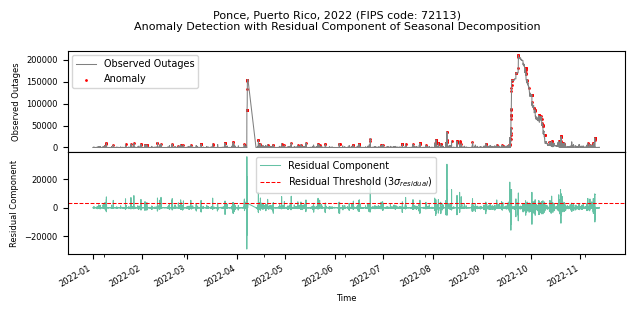

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose

def seasonal_decomp_resid_anomaly_plot(df, fips):
    decompose = seasonal_decompose(df.loc[fips, 'sum'].interpolate(), model='additive', period=16)
    decomp_df = pd.DataFrame({
        'residual': decompose.resid,
        'observed': decompose.observed,
        'year': df.loc[fips, 'year'],
        })
    county, state = df.loc[fips, ['county', 'state']].iloc[0]
    decomp_df = decomp_df.where(decomp_df['year'] == 2022).dropna()
    fig, ax = plt.subplots(2, 1, figsize=(5.75 * 1.25, 2.5 * 1.25), sharex=True)
    label_font_size = 6
    legend_font_size = 7
    # set line width to 0.5
    plt.rcParams['lines.linewidth'] = 0.75
    # threshold = (decomp_df['residual'] / 0.6745).median() * 5
    threshold = decomp_df['residual'].std() * 3
    decomp_df['anomaly'] = decomp_df['residual'] > threshold

    decomp_df[['observed']].plot(ax=ax[0], color='grey', label='Observed Outages')
    ax[0].set_ylabel('Observed Outages', fontsize=label_font_size)
    ax[0].scatter(decomp_df[decomp_df['anomaly']].index, decomp_df['observed'][decomp_df['anomaly']], color='r', label='Anomaly', s=1)
    ax[0].legend(["Observed Outages", "Anomaly"], fontsize=legend_font_size)

    decomp_df[['residual']].plot(ax=ax[1], label='Residual Component')
    ax[1].set_ylabel('Residual Component', fontsize=label_font_size)
    # ax[1].legend(["Residual Component"], fontsize=legend_font_size)
    ax[1].axhline(y=threshold, color='r', linestyle='--', label='Residual Threshold')
    ax[1].legend(["Residual Component", "Residual Threshold ($3\sigma_{residual}$)"], fontsize=legend_font_size)
    # plt.legend()
    # for i in range(4):
    #     # ax[i].get_legend().remove()
    #     ax[i].legend()
    ax[-1].set_xlabel('Time', fontsize=6)
    # set font size of ylabels, xlabels, legend, and ticks
    for i in range(2):
        ax[i].tick_params(axis='y', labelsize=6)
        ax[i].tick_params(axis='x', labelsize=6)
        # ax[i].legend(fontsize=6)
    # ax[0].legend(["Observed Outages"], fontsize=4)
    # plt.legend()

    plt.subplots_adjust(hspace=0)
    # adjust top vertical space
    # plt.tight_layout()
    fig.subplots_adjust(top=0.85)
    plt.suptitle(f'{county}, {state}, 2022 (FIPS code: {fips})\nAnomaly Detection with Residual Component of Seasonal Decomposition', fontsize=8)
    # get rid of horizontal space between suptitle and subplot
    return fig

fig = seasonal_decomp_resid_anomaly_plot(df, 72113)

In [19]:
fig.savefig("ponce-puerto-rico-residual-anomaly-detection.pdf", bbox_inches='tight')

## Isolation Forest


In [116]:
from sklearn.ensemble import IsolationForest
?IsolationForest

Init signature:
IsolationForest(
    *,
    n_estimators=100,
    max_samples='auto',
    contamination='auto',
    max_features=1.0,
    bootstrap=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
)
Docstring:     
Isolation Forest Algorithm.

Return the anomaly score of each sample using the IsolationForest algorithm

The IsolationForest 'isolates' observations by randomly selecting a feature
and then randomly selecting a split value between the maximum and minimum
values of the selected feature.

Since recursive partitioning can be represented by a tree structure, the
number of splittings required to isolate a sample is equivalent to the path
length from the root node to the terminating node.

This path length, averaged over a forest of such random trees, is a
measure of normality and our decision function.

Random partitioning produces noticeably shorter paths for anomalies.
Hence, when a forest of random trees collectively produce shorter path
len

In [119]:
df.loc[1031]

,county,state,sum,year
run_start_time,,,,
2014-11-01 19:30:00,Coffee,Alabama,2.0,2014
2014-11-01 19:45:00,0,0,0.0,2014
2014-11-01 20:00:00,0,0,0.0,2014
2014-11-01 20:15:00,0,0,0.0,2014
2014-11-01 20:30:00,0,0,0.0,2014
...,...,...,...,...
2022-11-12 16:45:00,Coffee,Alabama,2.0,2022
2022-11-12 17:00:00,Coffee,Alabama,2.0,2022
2022-11-12 17:15:00,Coffee,Alabama,2.0,2022


In [21]:
from sklearn.ensemble import IsolationForest

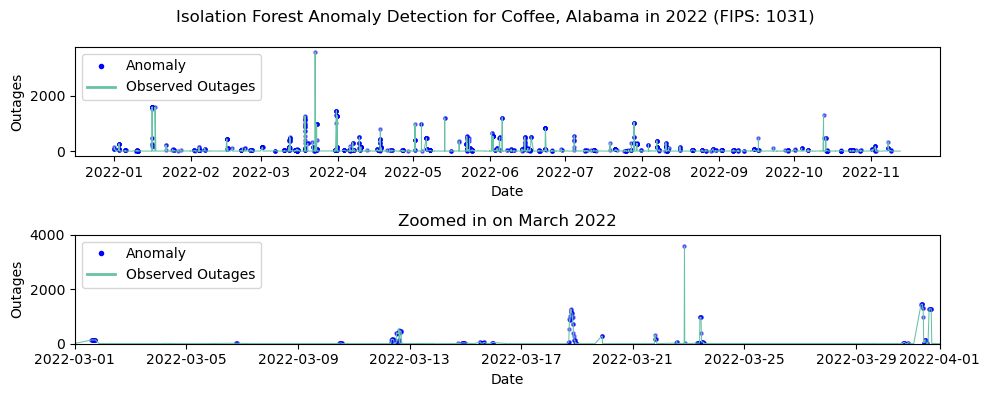

In [24]:
from matplotlib.lines import Line2D

def isolation_forest_plot(ts, cols):
    model = IsolationForest(random_state=0)
    model = model.fit(ts[cols])
    ts.loc[:, 'anomaly'] = model.predict(ts[cols])
    ts.loc[:, 'anomaly'] = ts['anomaly'].map({1: 0, -1: 1})
    ts.loc[:, 'anomaly_score'] = model.decision_function(ts[cols])

    fig, ax = plt.subplots(2, 1, figsize=(10, 4))
    axes = fig.axes
    palette = sns.color_palette()
    sns.lineplot(data=ts, x=ts.index, y='sum', ax=ax[0], color=palette[0])
    anomalies_year = ts[(ts['anomaly'] == 1)]
    ax[0].scatter(anomalies_year.index, anomalies_year['sum'], label='anomaly', color='blue', alpha=0.5, s=5)
    # ax[0].get_legend().remove()
    # create legend elements
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='Anomaly',
                                markerfacecolor='b', markersize=5), 
                        Line2D([0], [0], color=palette[0], lw=2, label='Observed Outages')]

    sns.lineplot(data=ts, x=ts.index, y='sum', ax=ax[1], color=palette[0])
    ax[1].scatter(anomalies_year.index, anomalies_year['sum'], label='anomaly', color='blue', alpha=0.5, s=5)
    ax[1].set_xlim(pd.to_datetime("03-01-2022"), pd.to_datetime("04-01-2022"))
    ax[1].set_ylim(0, 4000)
    ax[1].set_title('Zoomed in on March 2022')

    # sns.lineplot(data=ts, x=ts.index, y='sum', ax=ax[2], color=palette[0])
    # ax[2].scatter(anomalies_year.index, anomalies_year['sum'], label='anomaly', color='blue', alpha=0.5, s=5)
    # ax[2].set_xlim(pd.to_datetime("03-01-2022"), pd.to_datetime("03-07-2022"))
    # ax[2].set_ylim(0, 500)
    # ax[2].set_title('Zoomed in on first week of March 2022')

    for i in range(2):
        ax[i].set_ylabel('Outages')
        ax[i].legend(handles=legend_elements, loc='upper left')
        ax[i].set_xlabel('Date')

    county, state = ts[['county', 'state']].iloc[0]
    fig.suptitle(f'Isolation Forest Anomaly Detection for {county}, {state} in 2022 (FIPS: 1031)')
    plt.tight_layout()

    return fig, ts[['anomaly']]

data = df.loc[1031].where(lambda df: df['year'] >= 2022).dropna()
fig, ts = isolation_forest_plot(data, ['sum'])

In [ ]:
fig.savefig('coffee-alabama-isolation-forest-identification.pdf', bbox_inches='tight')